# Convolutional Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec
import pickle
import gzip

In [2]:
!wget http://www.cs.colostate.edu/~anderson/cs480/notebooks/nn4.tar
!tar xvf nn4.tar

--2017-04-23 10:29:37--  http://www.cs.colostate.edu/~anderson/cs480/notebooks/nn4.tar
Resolving www.cs.colostate.edu (www.cs.colostate.edu)... 129.82.45.114
Connecting to www.cs.colostate.edu (www.cs.colostate.edu)|129.82.45.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51200 (50K) [application/x-tar]
Saving to: ‘nn4.tar’

nn4.tar             100%[===================>]  50.00K  --.-KB/s    in 0.01s   

2017-04-23 10:29:38 (4.30 MB/s) - ‘nn4.tar’ saved [51200/51200]

x neuralnetworksbylayer.py
x layers.py
x scaledconjugategradient.py


In [3]:
import neuralnetworksbylayer as nn

Get data from [DeepLearning Tutorial](http://deeplearning.net/tutorial/gettingstarted.html), or using next code cell.

In [5]:
!wget http://www.cs.colostate.edu/~anderson/cs480/notebooks/mnist.pkl.gz

--2017-03-18 22:21:32--  http://www.cs.colostate.edu/~anderson/cs480/notebooks/mnist.pkl.gz
Resolving www.cs.colostate.edu (www.cs.colostate.edu)... 129.82.45.114
Connecting to www.cs.colostate.edu (www.cs.colostate.edu)|129.82.45.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  4.44MB/s    in 4.2s    

2017-03-18 22:21:37 (3.68 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [4]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xorig = np.vstack([a.reshape((28, 28, 1))[np.newaxis, :, :, :] for a in train_set[0]])
Torig = np.array(train_set[1]).reshape((-1,1))

Xtest = np.vstack([a.reshape((28,28,1))[np.newaxis,:,:,:] for a in test_set[0]])
Ttest = np.array(test_set[1]).reshape((-1,1))

Xorig.shape, Torig.shape, Xtest.shape, Ttest.shape

((50000, 28, 28, 1), (50000, 1), (10000, 28, 28, 1), (10000, 1))

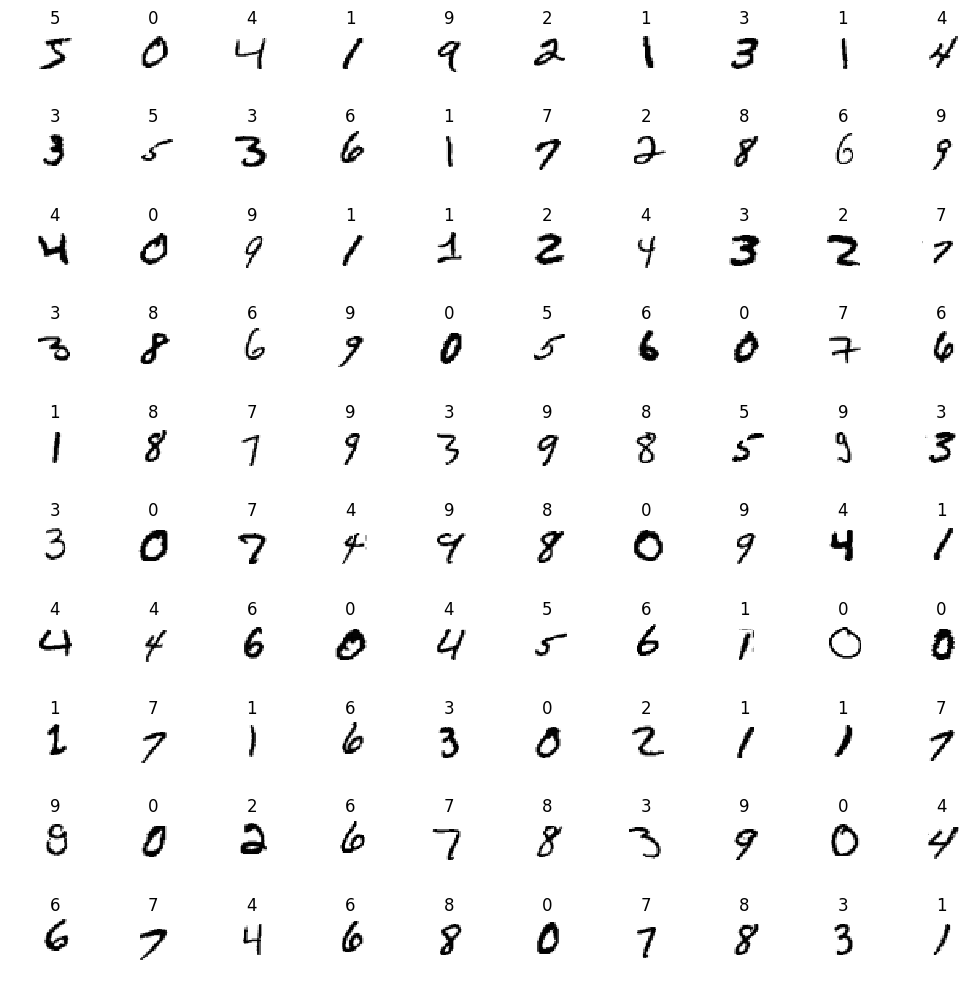

In [5]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(-Xorig[i,:].reshape((28,28)),interpolation='nearest',cmap='gray')
    plt.axis('off')
    plt.title(str(Torig[i][0]))
plt.tight_layout()

Try training with just 100 samples of each digit.

In [6]:
if False:
    nEach = 100
    useThese = []
    for digit in range(10):
        useThese += np.where(Torig == digit)[0][:nEach].tolist()
    useThese = np.array(useThese)
    np.random.shuffle(useThese)
    X = Xorig[useThese,:]
    T = Torig[useThese,:]
    del Xorig # to save memory
    del Yorig
else:
    X = Xorig
    T = Torig
X.shape, T.shape

((50000, 28, 28, 1), (50000, 1))

Make a neural network with the first layer being a convolutional layer of 20 units, with each unit learning a 5x5 matrix of weights to be applied to all 5x5 patches in the image with a stride of 1.  The second layer is a usual fully-connected layer.  The third layer is the usual fully-connected layer with 10 units. The final layer is a multinomial output layer.

In [7]:
imageSize = 28
nChannels = 1
 
nnet = nn.NeuralNetworkConvolutionalClassifier(
    nUnits=[nChannels, 20, 10, 10, len(np.unique(T))],
    inputSize=[imageSize, imageSize],
    windowSizes=[[5, 5], [10, 10]],
    windowStrides=[[1, 1], [2, 2]])

To avoid memory errors, train in minibatches.

Applying nnet.use to large matrix X or Xtest causes memory error.  So, we will use the following function to compute the output of the nnet.use function with minibatches.

In [8]:
def useMinibatch(nnet,X,minibatchSize):
    output = np.zeros((X.shape[0],1))
    for first in range(0,X.shape[0], minibatchSize):
        justThese = slice(first, first+minibatchSize)
        output[justThese,:] = nnet.use(X[justThese,:])
    return output

In [9]:
def trainMiniBatches(nReps):
    likelihoods = []
    minibatchIncrement = 1000
    for reps in range(nReps):
        roworder = np.arange(X.shape[0])
        np.random.shuffle(roworder)
        for first in range(0, X.shape[0], minibatchIncrement):
            
            useThese = slice(first, first+minibatchIncrement)
            
            nnet.train(X[roworder[useThese], :], T[roworder[useThese], :],nIterations=10, verbose=False)
            
            likelihoods += nnet.getErrorTrace()
            print('Minibatch from',first,'to',first+minibatchIncrement,'Final likel',likelihoods[-1])
        p = useMinibatch(nnet,X,minibatchIncrement)
        nTest = Xtest.shape[0] # 100
        ptest = useMinibatch(nnet,Xtest,minibatchIncrement)
        print("Rep {}. Fraction correct: Training {} Testing {}".format(reps,np.sum(p==T)/len(T),
                                                                np.sum(ptest==Ttest[:nTest,:])/nTest))
    return likelihoods

In [10]:
import time

In [11]:
starttime = time.time()
likelihoods = trainMiniBatches(2)
print(time.time() - starttime,'seconds')

Minibatch from 0 to 1000 Final likel 0.8416947732520564


/s/parsons/e/fac/anderson/public_html/cs480/notebooks/neuralnetworksbylayer.py:220: RuntimeWarning: divide by zero encountered in log
  return -np.mean(T * np.log(Y))
/s/parsons/e/fac/anderson/public_html/cs480/notebooks/neuralnetworksbylayer.py:220: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(T * np.log(Y))


Minibatch from 1000 to 2000 Final likel 0.8507108620016313
Minibatch from 2000 to 3000 Final likel 0.8565747383552924
Minibatch from 3000 to 4000 Final likel 0.9421281121146317
Minibatch from 4000 to 5000 Final likel 0.9540395668168241
Minibatch from 5000 to 6000 Final likel 0.9547708665532074
Minibatch from 6000 to 7000 Final likel 0.9604684098045712
Minibatch from 7000 to 8000 Final likel 0.9700244941879417
Minibatch from 8000 to 9000 Final likel 0.9768087060675815
Minibatch from 9000 to 10000 Final likel 0.9796184227091566
Minibatch from 10000 to 11000 Final likel 0.9853186456754589
Minibatch from 11000 to 12000 Final likel 0.9850839786502644
Minibatch from 12000 to 13000 Final likel 0.9872350829376418
Minibatch from 13000 to 14000 Final likel 0.9871074508116964
Minibatch from 14000 to 15000 Final likel 0.9872404022308419
Minibatch from 15000 to 16000 Final likel 0.9893633090456944
Minibatch from 16000 to 17000 Final likel 0.9906762190760617
Minibatch from 17000 to 18000 Final likel

In [12]:
ptest = useMinibatch(nnet,Xtest,200)
nWrong = np.sum(ptest != Ttest)
print(nWrong, nWrong/len(Ttest))

255 0.0255


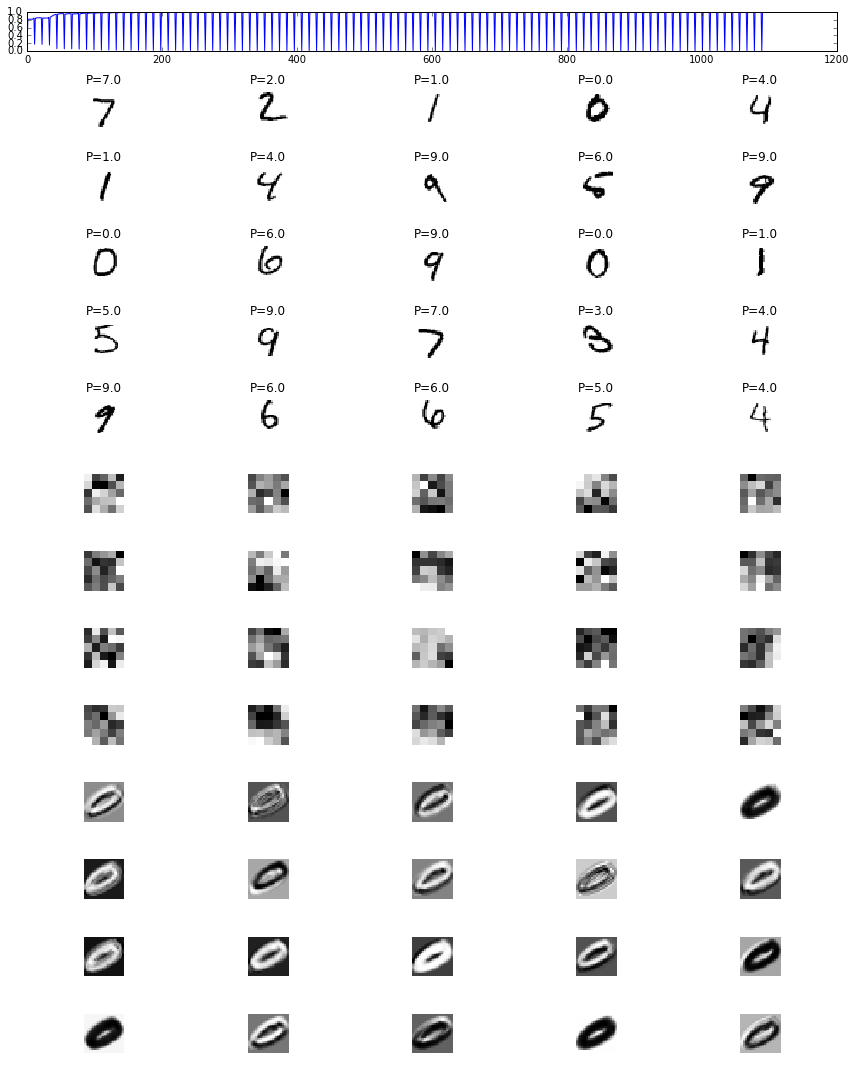

In [13]:
plt.figure(figsize=(12,15))
gs = gridspec.GridSpec(14, 5)
plt.subplot(gs[0, 0:5])
plt.plot(nnet.getErrorTrace())

ndigits = 25
for i in range(ndigits):
    plt.subplot(gs[1+int(i/5), i % 5])
    plt.imshow(-Xtest[i, :].reshape((imageSize, imageSize)), interpolation='nearest', cmap=plt.cm.gray)
    plt.title('P=' + str(ptest[i][0]))
    plt.axis('off')

    cvlay = nnet.layers[0]
    cw = cvlay.W[1:,:]
    nh = min(cvlay.nUnits,20)
    for i in range(nh):
        plt.subplot(gs[6+int(i/5),i%5])
        plt.imshow(cw[:,i].reshape(cvlay.windowSizes), interpolation='nearest', cmap=plt.cm.gray)
        plt.axis('off')
    cy = cvlay.Y.reshape((-1,24,24,20))
    for i in range(nh):
        plt.subplot(gs[10+int(i/5),i%5])
        plt.imshow(cy[0,:,:,i], interpolation='nearest', cmap=plt.cm.gray)
        plt.axis('off')
plt.tight_layout()

In [14]:
def drawFirstLayerOutputs(nnet,X):
    nnet.use(X)
    nSamples = X.shape[0]
    imageSize = int(np.sqrt(X.shape[1]))
    cvlay = nnet.layers[0]
    nUnits = cvlay.nUnits
    wrow,wcol = cvlay.nWindows
    y = cvlay.Y.reshape((-1,wrow,wcol,nUnits))
    plt.figure(figsize=(12,2*nSamples))
    gs = gridspec.GridSpec(nSamples*2,10)
    for i in range(nSamples):
        for h in range(nUnits):
            plt.subplot(gs[i*2 + int(h/10), h % 10])
            plt.imshow(-y[i,:,:,h], interpolation='nearest',cmap='gray')
            plt.axis('off')

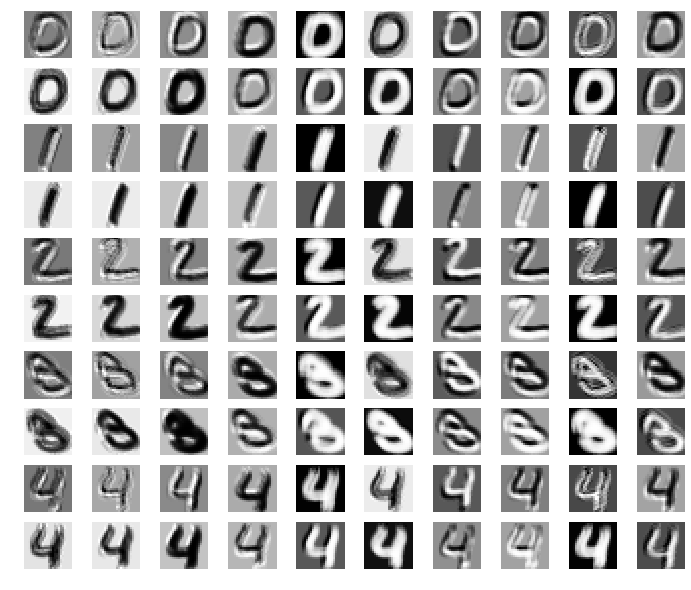

In [15]:
drawFirstLayerOutputs(nnet,Xtest[[10, 5, 1, 18, 4],:])

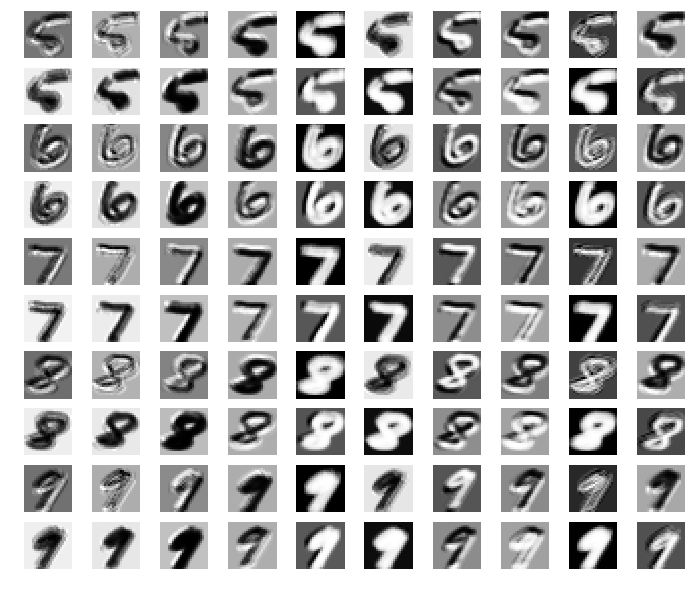

In [16]:
drawFirstLayerOutputs(nnet,Xtest[[8, 11, 0, 61, 20],:])

In [17]:
def drawSecondLayerOutputs(nnet,X):
    nnet.use(X)
    nSamples = X.shape[0]
    imageSize = int(np.sqrt(X.shape[1]))
    cvlay = nnet.layers[1]
    nUnits = cvlay.nUnits
    wrow,wcol = cvlay.nWindows
    y = cvlay.Y.reshape((-1,wrow,wcol,nUnits))
    plt.figure(figsize=(12,nSamples))
    gs = gridspec.GridSpec(nSamples,10)
    for i in range(nSamples):
        for h in range(nUnits):
            plt.subplot(gs[i*1, h])
            plt.imshow(-y[i,:,:,h], interpolation='nearest',cmap='gray')
            plt.axis('off')

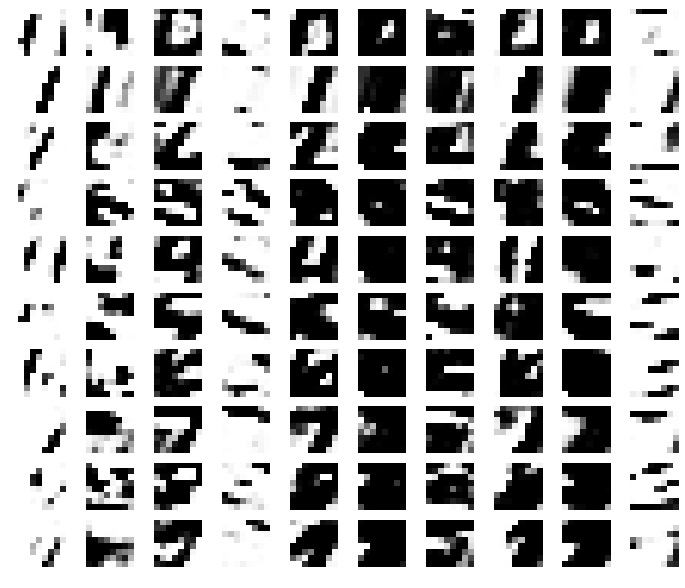

In [18]:
drawSecondLayerOutputs(nnet,Xtest[[10, 5, 1, 18, 4, 8, 11, 0, 61, 20]])